# 共同代码

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
plt.rcParams["font.family"] = "Times New Roman"

import subprocess, locale

def pdfcrop(filename: str):
    res = subprocess.run(
        ["pdfcrop", filename, filename],
        capture_output=True,      # 捕获 stdout / stderr
        text=False                # 先拿 bytes
    )

    # ---- 打印并解析输出 ----
    enc = locale.getpreferredencoding()
    stdout = res.stdout.decode(enc, errors="replace")
    stderr = res.stderr.decode(enc, errors="replace")

    if res.returncode != 0:
        print("pdfcrop 失败，返回码 =", res.returncode)
        print("---- stderr ----\n", stderr)
        print("---- stdout ----\n", stdout)
        # 也可直接 raise
        raise RuntimeError("pdfcrop failed")

    print(stdout)

# 绘制国家数统计图

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 获取自定义色板，适用于 11 个项目
theme_palette = sns.color_palette("tab20", 20)
sns.set_palette(theme_palette)

# 设置 seaborn 样式和字体
sns.set_theme(style="whitegrid", font="Times New Roman", font_scale=1.1, rc={"axes.linewidth": 1.5})

# -------- 1. 读取与统计 --------
file_path = './literatures/国家列表.xlsx'
df_raw = pd.read_excel(file_path, header=None)

country_counts = (
    df_raw[0]
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Country', 0: 'Frequency'})
)

# -------- 2. 取 Top-20 并按频数升序排列 --------
top_n = 20
top_counts = (
    country_counts.head(top_n)
    .sort_values('count', ascending=False)   # 升序方便自下而上
)

# -------- 3. seaborn 主题与字体 --------
sns.set_theme(
    context="talk",          # 字体放大：'paper' 'notebook' 'talk' 'poster'
    style="whitegrid",       # 白底+网格
    font="Times New Roman"   # 改成系统已有英文字体；若要中文可换 SimHei/Noto
)

# -------- 4. 绘图 --------
fig, ax = plt.subplots(figsize=(11, 8))

sns.barplot(
    data=top_counts,
    x='count',
    y='Frequency',
    palette=theme_palette,   # 你也可改成 'rocket', 'mako', 'crest' 等
    ax=ax,
    orient='h'
)

# 在条形末端标注数值
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + max(top_counts['count']) * 0.01,
        p.get_y() + p.get_height() / 2,
        f"{int(width)}",
        va='center',
        ha='left',
        fontsize=16
    )

# 坐标轴 & 标题
ax.set_xlabel("Frequency", fontsize=18, labelpad=8)
ax.set_ylabel("")  # 已经有 y 轴国家名，可空
# ax.set_title("Countries (Top 20)", fontsize=20, weight='bold', pad=15)

# 调整刻度大小
ax.tick_params(axis='both', labelsize=18)

# 去掉顶部与右侧边框
sns.despine(ax=ax, top=True, right=True)
# 设置坐标轴边框颜色和粗细
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_edgecolor("#333")  # 深灰色边框


plt.tight_layout()
plt.show()

filename="../imgs/countries.pdf"
fig.savefig(filename)
pdfcrop(filename)

In [ ]:
pdfcrop(filename)

# 绘制项目类型统计图

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
plt.rcParams["font.family"] = "Times New Roman"

# 定义自定义调色板（可为 RGB 或十六进制）
custom_palette = [
    '#9bbf8a', 
    '#82afda', 
    '#f79059',
    '#e7dbd3', 
    '#c2bdde',  
    '#8dcec8', 
    '#add3e2',  
    '#3480b8',
    '#ffbe7a',
    '#fa8878',
]
# custom_palette = sns.color_palette("tab20b", 10)
# 使用自定义 palette 可视化显示
# sns.set_palette(custom_palette)
# sns.palplot(custom_palette)
# 设置 seaborn 样式美化图表
# sns.set_theme(style="whitegrid", font="Times New Roman", font_scale=1.1, rc={"axes.linewidth": 1.2})

# 读取上传的 Excel 文件
file_path = "Year-projectType.xlsx"
df = pd.read_excel(file_path)

# 将多项目类型分割后展开，使每种类型都能单独统计
df_expanded = df.copy()

df_expanded['Project types'] = df_expanded['Project types'].str.split('+')
df_expanded = df_expanded.explode('Project types')

df_expanded

Project types  Year
0      Excavation  2025
0          Tunnel  2025
0           Urban  2025
1      Excavation  2021
1           Slope  2021
..            ...   ...
660         Slope  2023
660        Tunnel  2023
661        Tunnel  2024
662        Tunnel  2023
663         Slope  2010

[1041 rows x 2 columns]

In [2]:
# 按照年份和项目类型统计数量
grouped = df_expanded.groupby(['Year', 'Project types']).size().reset_index(name='Count')
# 生成透视表：行是年份，列是项目类型，值是数量
pivot_table = grouped.pivot(index='Year', columns='Project types', values='Count').fillna(0).astype(int)
if 'Total' in pivot_table.columns:
    pivot_table = pivot_table.drop(columns='Total')

pivot_table['Total'] = pivot_table.sum(axis=1)
# 插入 2007 年的行
new_row = pd.DataFrame([{}], index=[2007])
pivot_table = pd.concat([pivot_table.iloc[:1], new_row, pivot_table.iloc[1:]]).fillna(0).astype(int)

# 拟合总数趋势线
# 排除 2025 年的数据
trend_data = pivot_table.drop(index=2025)
x = trend_data.index.values.reshape(-1, 1)
y = trend_data['Total'].values
# 5阶多项式拟合
poly = PolynomialFeatures(degree=15)
X_poly = poly.fit_transform(x)
model_poly = LinearRegression()
model_poly.fit(X_poly, y)
y_poly_pred = model_poly.predict(X_poly)

# 拟合线性回归模型
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# 计算回归方程和决定系数 R^2
coeffs = model_poly.coef_
intercept = model_poly.intercept_
R2 = model_poly.score(X_poly, y)
equation = f"y = {' + '.join([f'{coeffs[i]:.3e}x^{i}' for i in range(len(coeffs))])} + {intercept:.3e}"

pivot_table

Bridge  Dam  Excavation  Flood  General  Mining  Roadbed  Slope  Tunnel  \
2006       0    0           0      0        0       0        0      1       0   
2007       0    0           0      0        0       0        0      0       0   
2008       0    0           0      0        1       0        0      0       0   
2009       0    0           0      1        0       0        0      2       0   
2010       0    0           0      0        2       1        1      3       0   
2011       0    2           0      1        0       0        0      2       0   
2012       0    0           0      0        0       0        1      0       3   
2013       0    0           0      0        0       0        0      0       0   
2014       0    0           0      0        2       1        1      3       2   
2015       0    1           0      0        0       1        1      5       1   
2016       0    3           0      2        3       2        1     10       4   
2017       1    1           0      0        2       1        2      5       3   
2018       1    2           0      0        2       3        4      8       2   
2019       3    6           1      3        1       9        6     14       6   
2020       2   12           0      8        5      12        5     23       6   
2021       1   12           2      6        8       9       14     31      10   
2022       2   15           2      4        6      22       16     48      13   
2023       3   26           4      3       10      25       21     52      21   
2024       5   24           2      4        2      38       22     57      20   
2025       3    8           1      4        2       8        8     23       9   

      Urban  Total  
2006      0      1  
2007      0      0  
2008      1      2  
2009      3      6  
2010      2      9  
2011      1      6  
2012      3      7  
2013      2      2  
2014      0      9  
2015      1     10  
2016      3     28  
2017     12     27  
2018      3     25  
2019     15     64  
2020     18     91  
2021     23    116  
2022     20    148  
2023     31    196  
2024     31    205  
2025     23     89

In [ ]:
# 为避免因颜色问题或图层顺序导致折线无法显示，重新设置颜色和图层顺序，确保折线在顶部可见
plt.figure(figsize=(16, 9))
ax1 = plt.gca()

# 绘制组合条形图
pivot_table.drop(columns='Total').plot(kind='bar', stacked=True, ax=ax1)

bar_container = pivot_table.drop(columns='Total').plot(kind='bar', stacked=True, ax=ax1, zorder=1, color=custom_palette)
# 在每个堆叠柱状图顶部添加总数文本标签
for idx, total in enumerate(pivot_table['Total']):
    ax1.text(idx, total + 1, str(total), ha='center', va='bottom', fontsize=24)


# 设置主轴标签和标题（含字体大小）
ax1.set_xlabel('Year', fontsize=28)
ax1.set_ylabel('Project Count by Type', fontsize=28)
# ax1.set_title('Project Type Count and Trend Line', fontsize=28)


# 创建右侧纵坐标轴
ax2 = ax1.twinx()

# 绘制总量趋势线，使用显眼颜色并调整图层在顶部
# 替代方式：传入 ax2.plot 的 x 为字符串
ax2.plot(trend_data.index.astype(str), y_poly_pred, color="#c82423", linestyle='-',
         linewidth=2,marker='o', markersize=10, label='Trend prediction line', zorder=5)

ax2.set_ylabel('Total per Year', fontsize=28)
# 添加趋势方程和R²文本
ax2.text(0.5, 0.35, f"R² = {R2:.4f}", transform=ax2.transAxes,
         fontsize=28, verticalalignment='top', bbox=dict(facecolor='white', alpha=0, linewidth=0))

# 调整布局和显示
## 设置所有刻度线方向为朝内
ax1.tick_params(axis='both', direction='in', labelsize=24)
ax2.tick_params(axis='y', direction='in', labelsize=24)

# 设置 X 轴刻度标签旋转
plt.setp(ax1.get_xticklabels(), rotation=45)

# 设置统计图边框粗细
for spine in ax1.spines.values():
    spine.set_linewidth(2)
for spine in ax2.spines.values():
    spine.set_linewidth(2)

# 同步左右轴的范围和刻度
# 设置左右 Y 轴范围一致，或根据需要自定义
min_y, max_y = 0, 250  # 可根据数据动态设置上下限
ax1.set_ylim(min_y, max_y)
ax2.set_ylim(min_y, max_y)
ax2.set_yticks(ax1.get_yticks())

# 启用主坐标轴网格
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=1)

## 合并图例
# 合并图例并放在左上角，仅显示一次
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2
# 去重（避免重复图例）
unique = dict(zip(all_labels, all_handles))
legend = ax1.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.02, 0.98), loc='upper left', fontsize=24, ncol=2)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor('black')

plt.tight_layout()

filename = "../imgs/Year_Types.pdf"
plt.savefig(filename)
plt.show()

# 裁剪 pdf
pdfcrop(filename)

# 绘制不同技术随年份变化的堆积面积图

In [8]:
# 定义自定义调色板（可为 RGB 或十六进制）
custom_palette = [
    '#9bbf8a', 
    '#82afda', 
    '#f79059',
    '#e7dbd3', 
    '#c2bdde',  
    '#8dcec8', 
    '#add3e2',  
    '#3480b8',
    '#ffbe7a',
    '#fa8878',
]
# custom_palette = sns.color_palette("tab20b", 10)
# 使用自定义 palette 可视化显示
# sns.set_palette(custom_palette)
# sns.palplot(custom_palette)

# 读取文件
file_path = './literatures/Year-Tech.xlsx'
df = pd.read_excel(file_path)

# 显示原始列名（避免列名误差）
print("原始列名:", df.columns.tolist())

# 统一列名
if 'Technologies' in df.columns and 'Year' in df.columns:
    df = df[['Year', 'Technologies']].dropna()
else:
    raise ValueError("列名必须包含 'Year' 和 'Technologies'")

# 将Technologies按+号分割，并展开
expanded = df.assign(Technologies=df['Technologies'].str.split('+')).explode('Technologies')

# 构建透视表（每年各技术出现频数）
pivot_table = expanded.pivot_table(index='Year', columns='Technologies', aggfunc='size', fill_value=0)

new_row = pd.DataFrame([{}], index=[2007])
pivot_table = pd.concat([pivot_table.iloc[:1], new_row, pivot_table.iloc[1:]]).fillna(0).astype(int)
# 添加 Total 列（每年技术总数）
pivot_table['Total'] = pivot_table.sum(axis=1)

pivot_table


原始列名: ['Technologies', 'Year']


GNSS(GPS)  Ground  InSAR  LiDAR  UAV  Total
2006          0       1      1      0    0      2
2007          0       0      0      0    0      0
2008          0       0      2      0    0      2
2009          0       1      2      2    0      5
2010          2       1      4      3    1     11
2011          0       1      2      0    1      4
2012          0       2      1      2    0      5
2013          0       1      1      0    0      2
2014          0       3      4      2    0      9
2015          0       2      1      4    1      8
2016          0       3      6      8    5     22
2017          3       6      9      6    5     29
2018          5       4      5      5    5     24
2019          5      12     16     12    9     54
2020          6      14     24      8   13     65
2021          7      16     27     11   17     78
2022          7      11     43     11   31    103
2023         15      13     59     11   24    122
2024          9      18     50     22   35    134
2025          4       9     30      5   15     63

C:\Users\admin\AppData\Local\Temp\ipykernel_19548\1774122952.py:27: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_vals[:-1], y_vals, deg=5)
C:\Users\admin\AppData\Local\Temp\ipykernel_19548\1774122952.py:27: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_vals[:-1], y_vals, deg=5)
C:\Users\admin\AppData\Local\Temp\ipykernel_19548\1774122952.py:27: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_vals[:-1], y_vals, deg=5)
C:\Users\admin\AppData\Local\Temp\ipykernel_19548\1774122952.py:27: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_vals[:-1], y_vals, deg=5)
C:\Users\admin\AppData\Local\Temp\ipykernel_19548\1774122952.py:27: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_vals[:-1], y_vals, deg=5)
C:\Users\admin\AppData\Local\Temp\ipykernel_19548\1774122952.py:27: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x_vals[:-1], y_vals, deg=5)


PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../imgs/Year_Tech.pdf'.



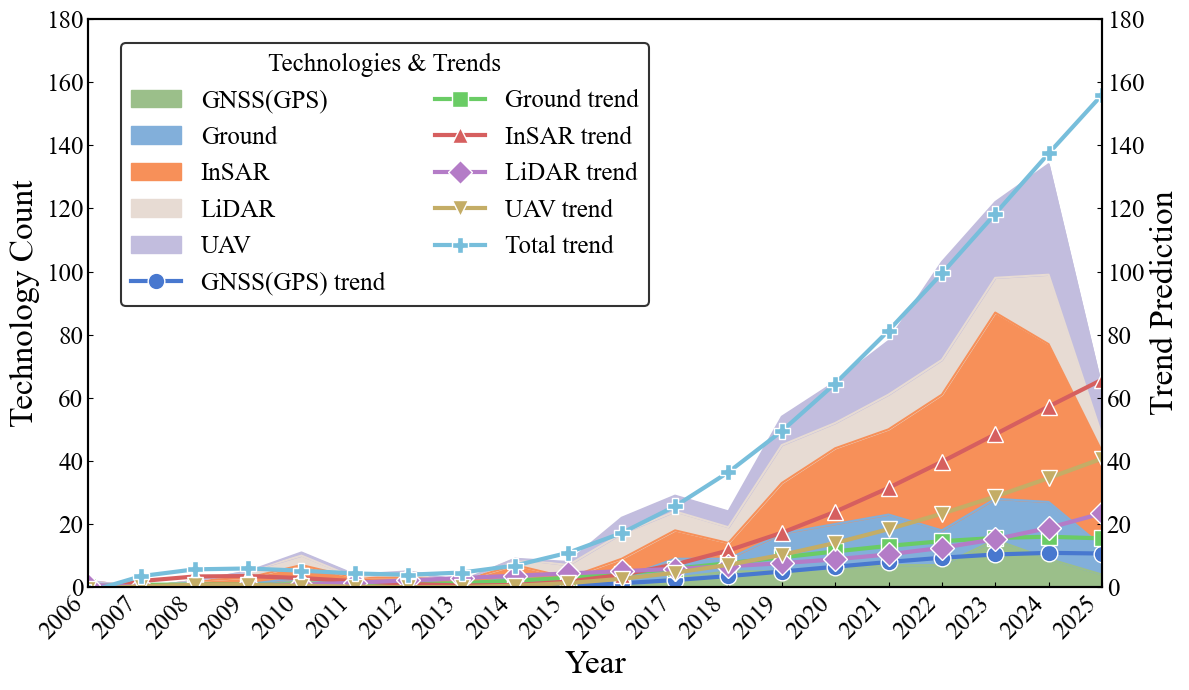

In [17]:
# 准备绘图
fig, ax1 = plt.subplots(figsize=(12, 7))

# 绘制堆积面积图（左 Y 轴）
pivot_table[pivot_table.columns[:-1]].plot.area(ax=ax1, stacked=True, color=custom_palette)
# ax1.set_title("Technologies over Years (Stacked Area Chart)")
ax1.set_xlabel("Year", fontsize=24)
ax1.set_ylabel("Technology Count", fontsize=24)
ax1.set_xticks(pivot_table.index)
ax1.set_xticklabels(pivot_table.index.astype(str), rotation=45, ha='right', fontsize=18)
# 坐标轴刻度朝内
ax1.tick_params(direction='in', labelsize=18)

# 设置外框边界
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

# 拟合趋势线（右 Y 轴）
ax2 = ax1.twinx()
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '*', '<', '>']
x_vals = pivot_table.index.values
trend_lines = []
for idx, tech in enumerate(pivot_table.columns):
    y_vals = pivot_table[tech].values[:-1]
    if np.count_nonzero(y_vals) > 1:
        z = np.polyfit(x_vals[:-1], y_vals, deg=5)
        p = np.poly1d(z)
        marker = markers[idx % len(markers)]
        line, = ax2.plot(
            x_vals, p(x_vals), linestyle='-', marker=marker, markersize=12, 
            linewidth=3, label=f"{tech} trend", 
            markeredgecolor='white', markeredgewidth=1
        )
        trend_lines.append(line)
# 设置右 Y 轴从 0 开始，坐标轴刻度朝内，外框
min_y, max_y = 0, 180  # 可根据数据动态设置上下限
ax1.set_ylim(min_y, max_y)
ax2.set_ylim(min_y, max_y)
ax2.set_yticks(ax1.get_yticks())
ax2.tick_params(direction='in', labelsize=18)
ax2.set_ylabel("Trend Prediction", fontsize=24)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

# 合并图例
# 合并图例，设置为两列，放在图内左上角
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(handles1 + handles2, labels1 + labels2, title="Technologies & Trends", 
                    loc='upper left', ncol=2, frameon=True, fontsize=18, title_fontsize=18, bbox_to_anchor=(0.02, 0.98))
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor('black')
# 去除网格
ax1.grid(False)
ax2.grid(False)

# X轴两端不留白
ax1.set_xlim(pivot_table.index.min(), pivot_table.index.max())

plt.tight_layout()

filename = "../imgs/Year_Tech.pdf"
plt.savefig(filename)
pdfcrop(filename)
plt.show()


# 关键词共现分析

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../imgs/keyword_network_2010-2014.pdf'.



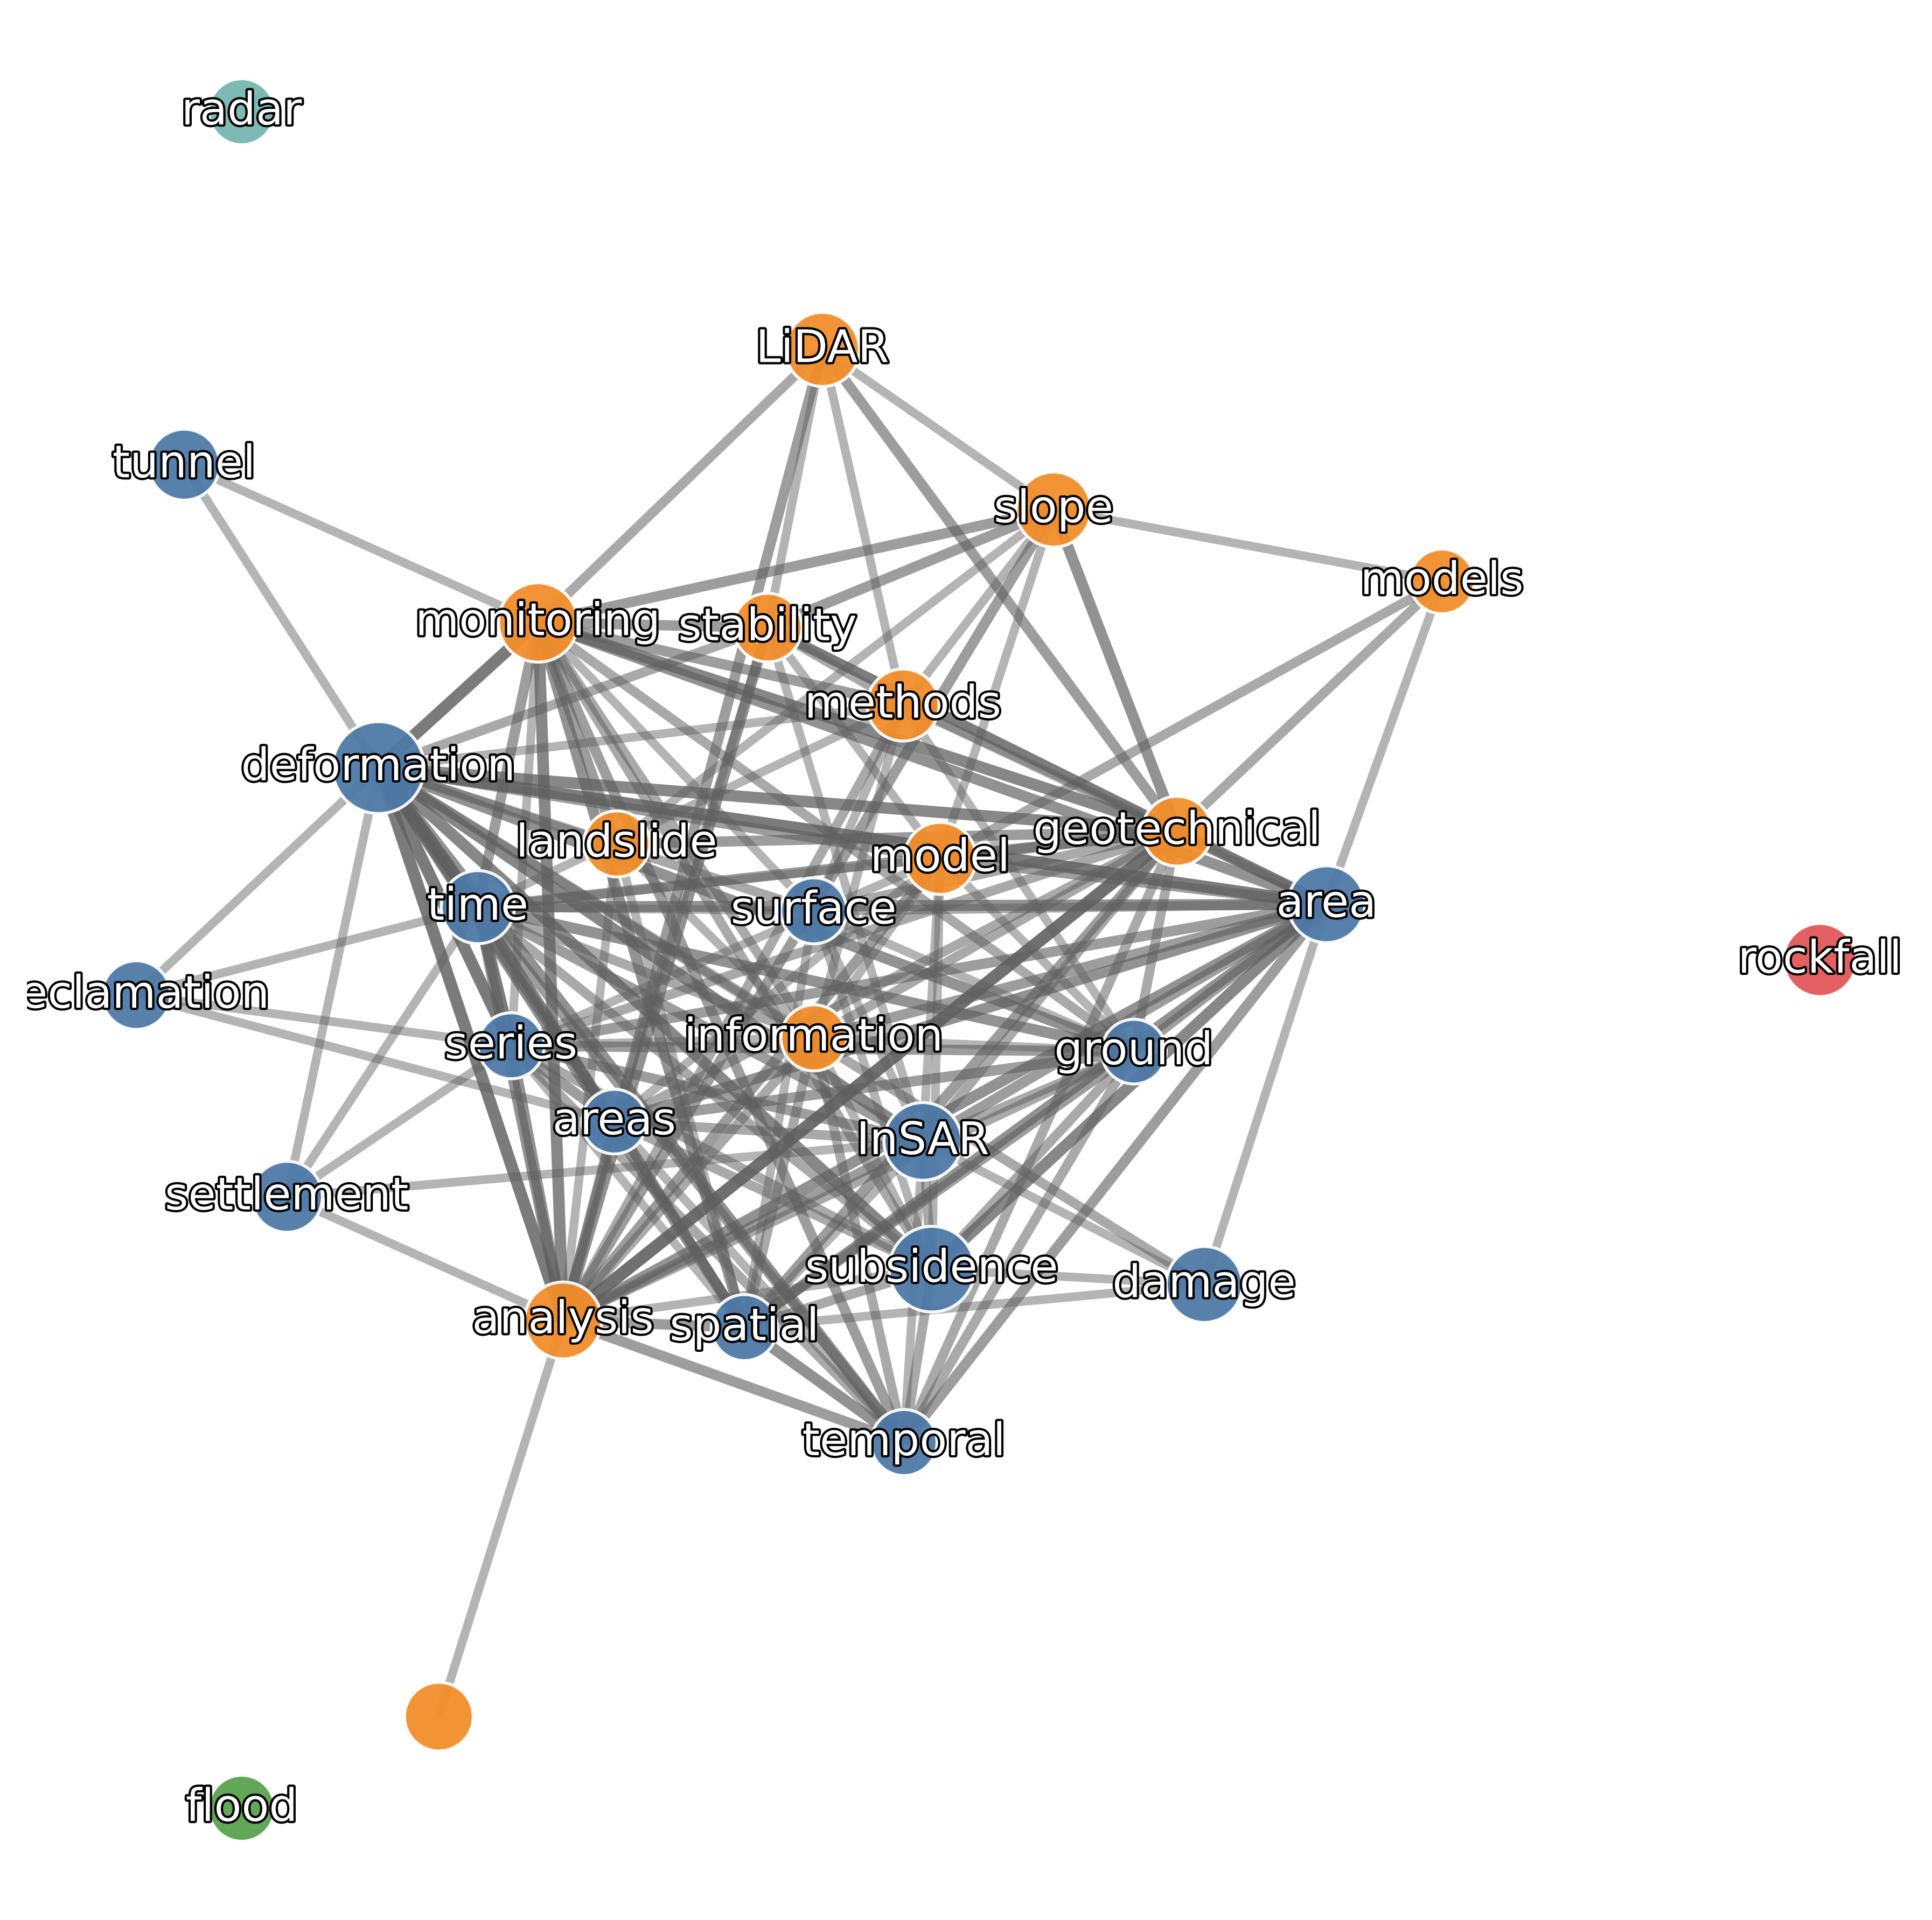

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../imgs/keyword_network_2015-2019.pdf'.



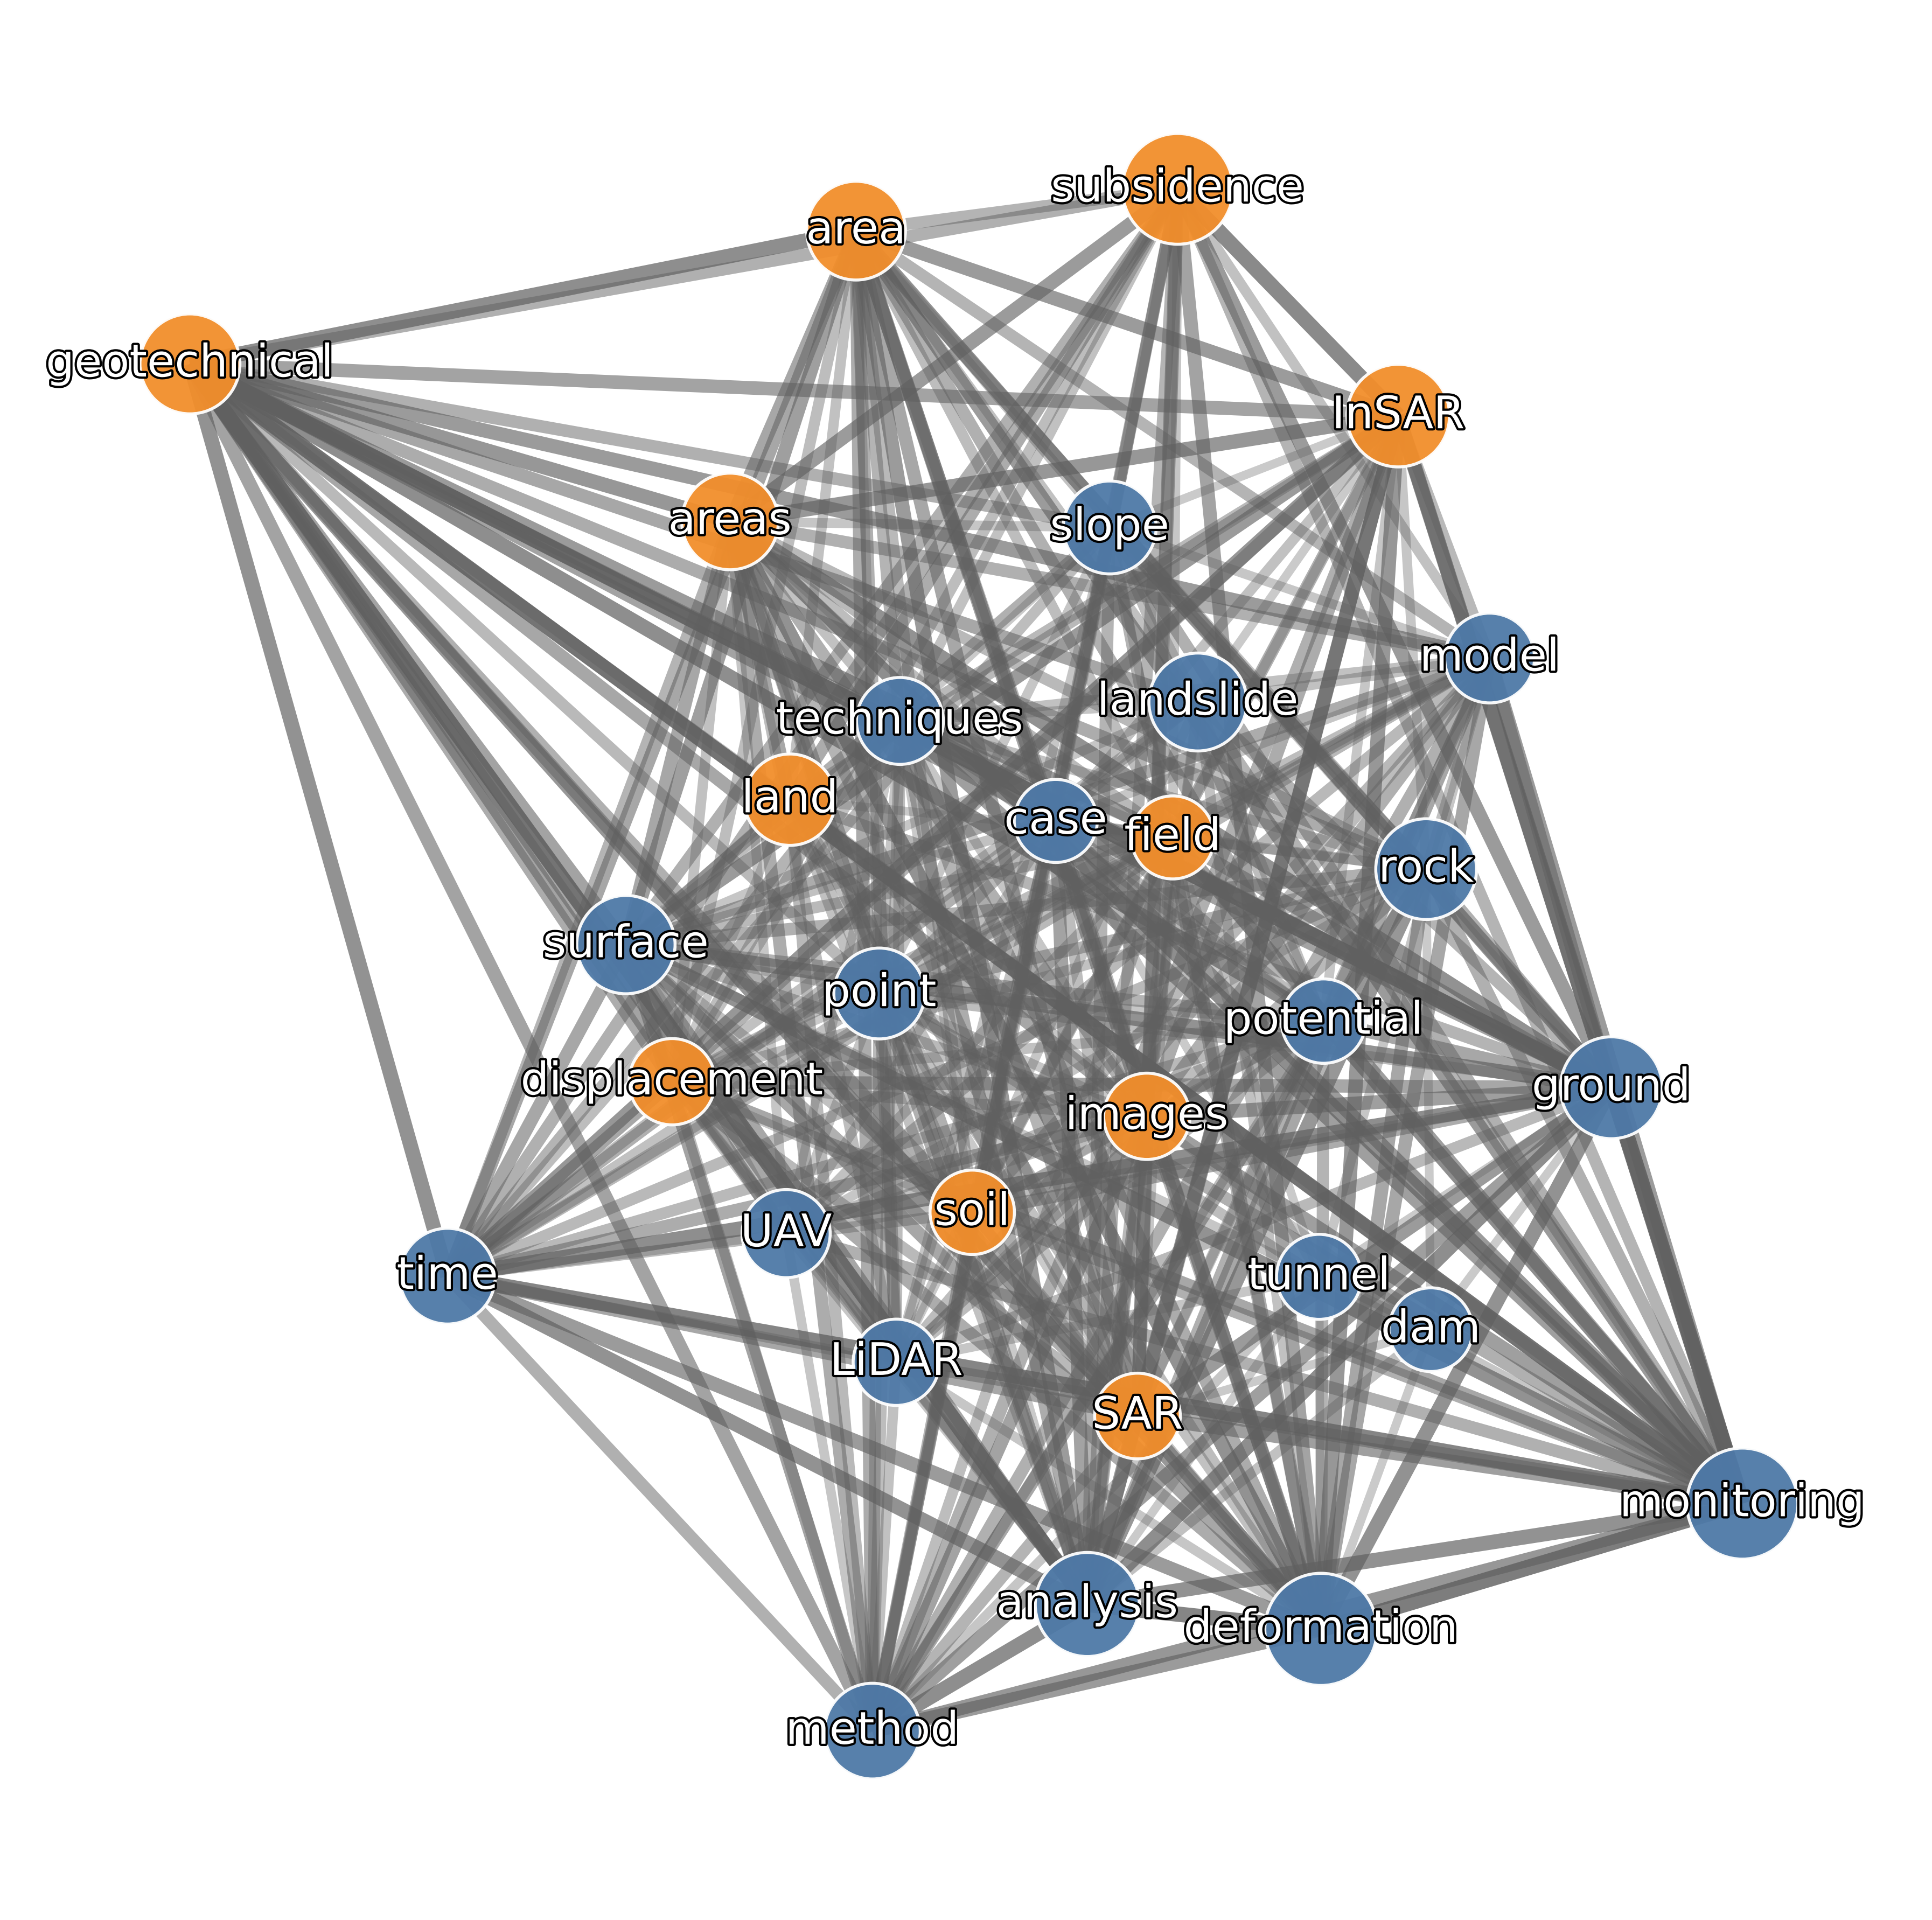

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../imgs/keyword_network_2020-2025.pdf'.



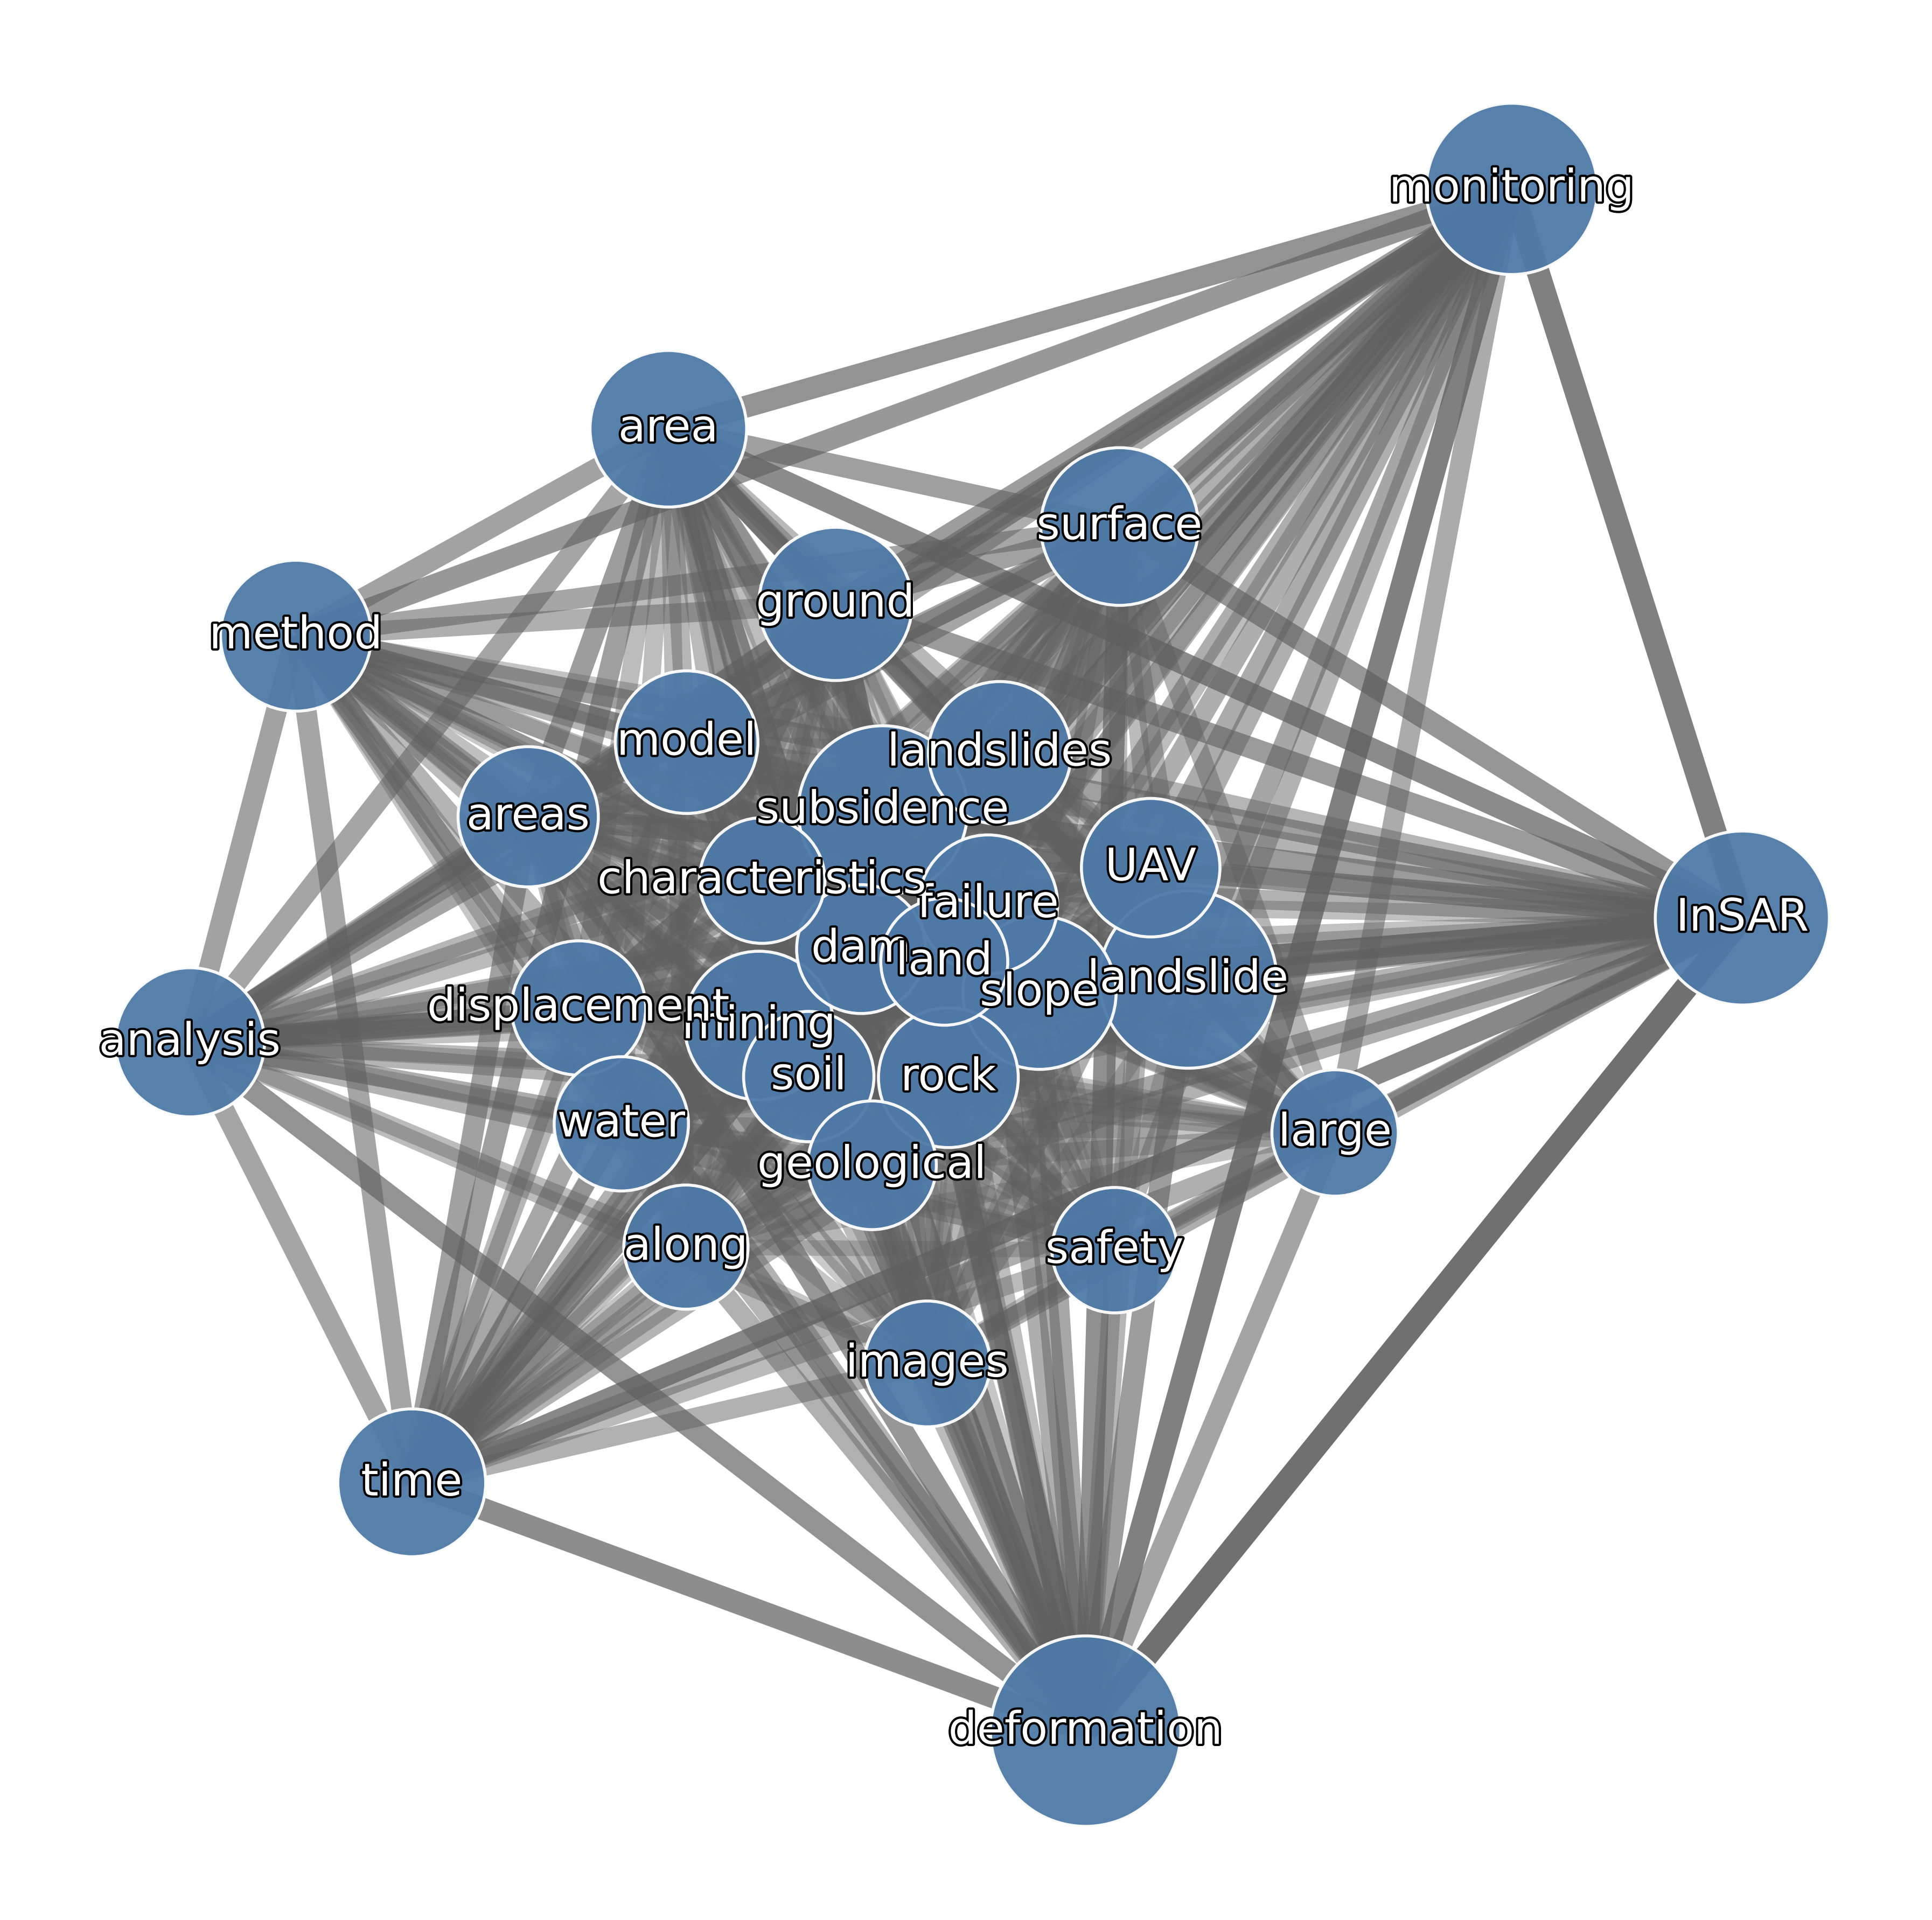

In [5]:
# -*- coding: utf-8 -*-
"""
Beautified keyword co‑occurrence network visualisation
=====================================================
This script refactors and polishes the original plotting routine.

Key improvements
----------------
1. **Consistent style** – uses the Tableau‑colour‑blind palette and global rcParams.
2. **Perceptual node sizing** – node radius ∝ √(frequency) so differences不太夸张。
3. **Edge aesthetics** – width = log( weight ), alpha = weight/max.
4. **Colour‑blind friendly communities** via *tab20c* colormap.
5. **Automatic label decluttering** –只给较大的节点显示标签。
6. **High‑resolution export** – figures saved为 300 DPI PNG.
7. **Modular functions** –更易复用与测试。

Dependencies
----
- pandas
- networkx (>=2.8)
- matplotlib
- community‑louvain *(Prior)*

运行
----
```bash
python beautified_networkx_plot.py  # 默认参数跑三段时间窗口
```
自定义参数可在脚本顶部常量块修改。
"""

import itertools
import math
import re
import collections
from pathlib import Path
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import networkx as nx
import pandas as pd


# ========= USER CONFIG ========= #
filename = "./literatures/Keyword Co-occurrence Network.xlsx"
FILE_PATH = Path(filename)
YEAR_COL = "Publication Year"
SEGMENTS: List[Tuple[int, int]] = [(2010, 2014), (2015, 2019), (2020, 2025)]
TOP_N = 30            # 关键词保留数量
EDGE_THRESH = 3       # 共现阈值
FIG_DPI = 500         # 导出分辨率
NODE_SCALE_FACTOR = 160  # 调大节点的面积系数
NODE_COLOR_PALETTE = [  # 颜色可改；不足时循环使用
    "#4E79A7", "#F28E2B", "#E15759", "#76B7B2",
    "#59A14F", "#EDC948", "#AF7AA1", "#FF9DA7",
    "#9C755F", "#BAB0AC", "#2F4B7C", "#FFBF00",
]
LABEL_SIZE_PT2 = 350  # 基础标签阈值
MIN_LABEL_AREA_PT2 = 250  # 2 条以上边时的次级阈值
RANDOM_SEED = 12340   # 布局随机种子
ISOLATE_RING_SCALE = 1.2  # 孤立节点环的半径系数
# ================================= #

plt.style.use("seaborn-v0_8-muted")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.titleweight": "bold",
    "axes.titlesize": 13,
    "savefig.bbox": "tight",
})

def color_of(comm_map, n: str) -> str:
    cid = comm_map.get(n, 0) % len(NODE_COLOR_PALETTE)  # ← 社区 ID 取模
    return NODE_COLOR_PALETTE[cid]


# ---- 停用词表（简版） ---- #
stopwords = set(
    """a about above after again against all am an and any are as at be because been before being below between both but by
    can cannot could did do does doing down during each few for from further had has have having he her here hers herself him
    himself his how i if in into is it its me more most my myself no nor not of off on once only or other our ours ourselves
    out over own same she should so some such than that the their theirs them themselves then there these they this those
    through to too under until up very was we were what when where which while who whom why with you your yours yourself
    yourselves using used high based study result results china new data also proposed""".split()
)

# ---------------------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------------------

def extract_keywords(text: str) -> List[str]:
    # tokens = [w.lower() for w in re.split(r"[^A-Za-z]+", str(text)) if len(w) > 2]
    tokens = [w for w in re.split(r"[^A-Za-z]+", str(text)) if len(w) > 2]
    return [w for w in tokens if w.lower() not in stopwords]

def build_graph(texts: List[str], top_n: int, edge_thresh: int) -> nx.Graph:
    wc: collections.Counter[str] = collections.Counter()
    docs_kw: List[set[str]] = []
    for txt in texts:
        kw = extract_keywords(txt)
        wc.update(kw)
        docs_kw.append(set(kw))
    top_kw = [w for w, _ in wc.most_common(top_n)]
    co_counts: collections.Counter[Tuple[str, str]] = collections.Counter()
    for kw_set in docs_kw:
        present = [w for w in kw_set if w in top_kw]
        for a, b in itertools.combinations(present, 2):
            co_counts[tuple(sorted((a, b)))] += 1
    G = nx.Graph()
    for kw in top_kw:
        G.add_node(kw, freq=wc[kw])
    for (a, b), wt in co_counts.items():
        if wt >= edge_thresh:
            G.add_edge(a, b, weight=wt)
    return G


def detect_communities(G: nx.Graph):
    try:
        import community as community_louvain  # type: ignore
        part = community_louvain.best_partition(G)
        comms: Dict[int, List[str]] = {}
        for n, cid in part.items():
            comms.setdefault(cid, []).append(n)
        return list(comms.values()), part
    except ImportError:
        comms = list(nx.algorithms.community.greedy_modularity_communities(G))
        part: Dict[str, int] = {}
        for cid, nodes in enumerate(comms):
            for n in nodes:
                part[n] = cid
        return [list(c) for c in comms], part


def compute_layout(G: nx.Graph, seed: int) -> Dict[str, Tuple[float, float]]:
    """主体布局 + 将孤立节点辐射到外围圆环。"""
    n = G.number_of_nodes()
    if n <= 40:
        pos = nx.kamada_kawai_layout(G, weight="weight")
    else:
        k = 2.5 / math.sqrt(n)
        pos = nx.spring_layout(G, seed=seed, k=k, iterations=300, weight="weight", scale=2)

    # 计算半径范围
    if pos:
        max_r = max(math.hypot(x, y) for x, y in pos.values())
    else:
        max_r = 1.0

    isolates = [node for node in G.nodes if G.degree(node) == 0]
    if isolates:
        angle_step = 2 * math.pi / len(isolates)
        for idx, node in enumerate(isolates):
            theta = idx * angle_step
            pos[node] = (
                ISOLATE_RING_SCALE * max_r * math.cos(theta),
                ISOLATE_RING_SCALE * max_r * math.sin(theta),
            )
    return pos


def plot_segment_network(
    G: nx.Graph,
    communities: List[List[str]],
    comm_map: Dict[str, int],
    period: str,
    seed: int,
    save_png: bool = True,
):
    pos = compute_layout(G, seed)

    node_sizes = [math.sqrt(G.nodes[n]["freq"]) * 90 for n in G.nodes]
    # cmap = cm.get_cmap("tab20c", len(communities))
    # node_colors = [cmap(comm_map.get(n, 0)) for n in G.nodes]
    node_colors = [color_of(comm_map, n) for n in G.nodes]

    fig, ax = plt.subplots(figsize=(9, 9), dpi=FIG_DPI)

    nx.draw_networkx_nodes(
        G,
        pos,
        ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors="white",
        linewidths=0.8,
        alpha=0.95,
    )

    if G.edges:
        max_w = max(nx.get_edge_attributes(G, "weight").values())
        for e in G.edges:
            w = G.edges[e]["weight"]
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=[e],
                ax=ax,
                width=0.8 + 1.1 * math.log1p(w),
                alpha=0.25 + 0.65 * (w / max_w),
                edge_color="#606060",
            )
        
    # label rules
    labels = {}
    for n, size in zip(G.nodes, node_sizes):
        if G.degree(n) == 0:
            labels[n] = n  # always label isolates
        elif (size > LABEL_SIZE_PT2) or (size > MIN_LABEL_AREA_PT2 and G.degree(n) > 1):
            labels[n] = n
    nx_labels = nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color="#fff", ax=ax)
    for t in nx_labels.values():
        t.set_path_effects([pe.withStroke(linewidth=1.2, foreground="#000")])

    # ax.set_title(
    #     f"{period}  •  Top {TOP_N} keywords  •  communities={len(communities)}",
    #     pad=8,
    # )
    ax.set_axis_off()

    file_names = f"../imgs/keyword_network_{period.replace(' ', '')}.pdf"
    if save_png:
        fig.savefig(file_names, dpi=FIG_DPI)
        pdfcrop(file_names)
    
    
    plt.show()


def main() -> None:
    df = pd.read_excel(FILE_PATH)
    if YEAR_COL not in df.columns:
        raise KeyError(f"Expected column '{YEAR_COL}' not found in {FILE_PATH.name}.")

    df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce").astype("Int64")
    df.dropna(subset=[YEAR_COL], inplace=True)

    for idx, (start, end) in enumerate(SEGMENTS):
        seg_df = df[(df[YEAR_COL] >= start) & (df[YEAR_COL] <= end)]
        if seg_df.empty:
            print(f"⚠ No records for {start}–{end}, skipping…")
            continue

        texts = (
            seg_df["Article Title"].fillna("") + " " + seg_df["Abstract"].fillna("")
        ).tolist()

        G = build_graph(texts, TOP_N, EDGE_THRESH)
        communities, comm_map = detect_communities(G)
        plot_segment_network(G, communities, comm_map, f"{start}-{end}", seed=RANDOM_SEED + idx)

main()


## 基于图的量化演化分析

In [6]:
import pandas as pd
import re, itertools, collections
import networkx as nx
from math import ceil

FILE_PATH = "./literatures/Keyword Co-occurrence Network.xlsx"
YEAR_COL = "Publication Year"
SEGMENTS = [(2010, 2014), (2015, 2019), (2020, 2025)]  # inclusive

# ----------------- helper functions -----------------
stopwords = set("""
a about above after again against all am an and any are aren't as at be because been before being below between both but by
can can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has
hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if
in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or other ought our
ours ourselves out over own same she she'd she'll she's should shouldn't so some such than that that's the their theirs
them themselves then there's these they they'd they'll they're they've this those through to too under until up very was
wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's
with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves
""".split())

def extract_keywords(text):
    tokens = [w.lower() for w in re.split(r"[^A-Za-z]+", str(text)) if len(w) > 2]
    return [w for w in tokens if w not in stopwords]

def build_graph(texts, top_n, edge_thresh):
    word_counts = collections.Counter()
    docs_kw = []
    for txt in texts:
        kw = extract_keywords(txt)
        word_counts.update(kw)
        docs_kw.append(set(kw))
    top_kw = [w for w, _ in word_counts.most_common(top_n)]
    co_counts = collections.Counter()
    for kw_set in docs_kw:
        present = [w for w in kw_set if w in top_kw]
        for a, b in itertools.combinations(present, 2):
            co_counts[tuple(sorted((a, b)))] += 1
    G = nx.Graph()
    for kw in top_kw:
        G.add_node(kw, freq=word_counts[kw])
    for (a, b), wt in co_counts.items():
        if wt >= edge_thresh:
            G.add_edge(a, b, weight=wt)
    return G

# ----------------- 1. Quantitative evolution -----------------
df = pd.read_excel(FILE_PATH)
df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce").astype("Int64")
df = df.dropna(subset=[YEAR_COL])

# build per-segment keyword frequency table
freq_table = {}
top_global = set()
for (start, end) in SEGMENTS:
    seg_df = df[(df[YEAR_COL] >= start) & (df[YEAR_COL] <= end)]
    texts = (seg_df["Article Title"].fillna("") + " " + seg_df["Abstract"].fillna("")).tolist()
    wc = collections.Counter()
    for t in texts:
        wc.update(extract_keywords(t))
    # keep top 40 each segment
    seg_top = dict(wc.most_common(40))
    freq_table[f"{start}-{end}"] = seg_top
    top_global.update(seg_top.keys())

# build combined DataFrame
rows = []
for kw in sorted(top_global):
    row = {"Keyword": kw}
    prev_val = None
    growth_cols = {}
    for seg in [f"{s}-{e}" for s, e in SEGMENTS]:
        val = freq_table.get(seg, {}).get(kw, 0)
        row[seg] = val
        if prev_val is not None:
            growth = (val - prev_val) / prev_val * 100 if prev_val else None
            growth_cols[f"Growth_{seg}"] = round(growth, 1) if growth is not None else None
        prev_val = val
    row.update(growth_cols)
    rows.append(row)

evolution_df = pd.DataFrame(rows).set_index("Keyword").sort_values(by="2020-2025", ascending=False)

# ----------------- 2. Sensitivity analysis -----------------
PARAM_TOP_N = [20, 30, 40]
PARAM_EDGE = [2, 3, 5]

sens_records = []
# use latest period 2020-2025 for sensitivity
seg_df = df[(df[YEAR_COL] >= 2020) & (df[YEAR_COL] <= 2025)]
texts_2020 = (seg_df["Article Title"].fillna("") + " " + seg_df["Abstract"].fillna("")).tolist()

for topn in PARAM_TOP_N:
    for thr in PARAM_EDGE:
        G = build_graph(texts_2020, topn, thr)
        # community and metrics
        communities = list(nx.algorithms.community.greedy_modularity_communities(G))
        if len(communities) > 1:
            modularity = nx.algorithms.community.modularity(G, communities)
        else:
            modularity = 0.0
        density = nx.density(G)
        sens_records.append({
            "TOP_N": topn,
            "EDGE_THRESH": thr,
            "Nodes": len(G),
            "Edges": len(G.edges),
            "Communities": len(communities),
            "Density": round(density, 3),
            "Modularity": round(modularity, 3)
        })

sens_df = pd.DataFrame(sens_records).sort_values(["TOP_N", "EDGE_THRESH"])


In [13]:
sens_df

TOP_N  EDGE_THRESH  Nodes  Edges  Communities  Density  Modularity
0     20            2     20    190            1    1.000         0.0
1     20            3     20    190            1    1.000         0.0
2     20            5     20    190            1    1.000         0.0
3     30            2     30    435            1    1.000         0.0
4     30            3     30    435            1    1.000         0.0
5     30            5     30    435            1    1.000         0.0
6     40            2     40    779            1    0.999         0.0
7     40            3     40    775            1    0.994         0.0
8     40            5     40    767            1    0.983         0.0